In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Manifold Methods for Dimension Reduction

Covered in this notebook:

* [Isomap](#Isomap)
* [Locally Linear Embedding (LLE)](#Locally-Linear-Embedding)
* [t-distributed Stochastic Neighbor Embedding (t-SNE)](#t-SNE)
* [Uniform Manifold Approximation and Projection (UMAP)](#UMAP)

## Setup of dataset, motivation, & PCA

### Setup

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE

# !pip install umap-learn
from umap import UMAP

from scipy.spatial.distance import pdist, squareform

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

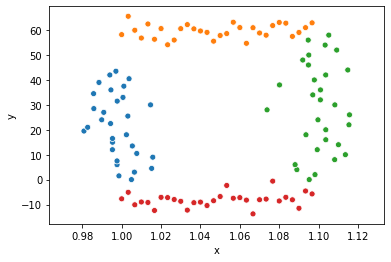

<IPython.core.display.Javascript object>

In [3]:
np.random.seed(42)

n = 30
sd = 0.01
mean1 = 1
mean3 = 1.1
mean5 = 1.2

x1 = np.random.normal(mean1, sd, n)
y1 = np.arange(n) * 1.5

x2 = np.arange(mean1, mean3, (mean3 - mean1) / n)
y2 = np.random.normal(n * 2, 3, n)

x3 = np.random.normal(mean3, sd, n)
y3 = np.arange(n) * 2

x4 = np.arange(mean1, mean3, (mean3 - mean1) / n)
y4 = np.random.normal(-8, 3, n)

x = np.hstack((x1, x2, x3, x4))
y = np.hstack((y1, y2, y3, y4))
group = ["a"] * n + ["b"] * n + ["c"] * n + ["d"] * n

df = pd.DataFrame({"x": x, "y": y, "group": group})
sns.scatterplot("x", "y", hue="group", data=df)
plt.legend().remove()
plt.show()

### Motivation

Our data here takes an interesting shape.  It's sort of rolled up.  The question that motivates the method we'll see is: 

How should we treat the below highlighted points?

The distance between them isn't huge in terms of our dataset's x and y coordinates, but if our data's true structure is a rolled up line of points, then the blue and orange points would be on opposite sides of this roll.  This means that these points should be as far away as possible.

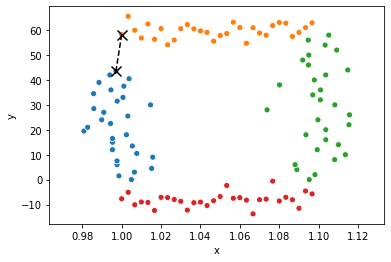

<IPython.core.display.Javascript object>

In [4]:
df = pd.DataFrame({"x": x, "y": y, "group": group})
sns.scatterplot("x", "y", hue="group", data=df)
plt.scatter([1.0, 0.997083], [58.194880, 43.5], marker="x", c="black", s=100)
plt.plot([1.0, 0.997083], [58.194880, 43.5], c="black", ls="--")
plt.legend().remove()
plt.show()

### PCA

Isolate the x and y columns and scale the data

In [5]:
X = df[["x", "y"]]

scaler = StandardScaler()
scaled = scaler.fit_transform(X)

<IPython.core.display.Javascript object>

Apply PCA to the data with one component, what do you expect the output to look like?

In [6]:
pca = PCA(1)
df["pc1"] = pca.fit_transform(scaled)

<IPython.core.display.Javascript object>

In [7]:
pca.explained_variance_ratio_

array([0.54060113])

<IPython.core.display.Javascript object>

Plot the first principal component colored by group (use the zero column for the y axis)

In [8]:
df["zero"] = 0

<IPython.core.display.Javascript object>

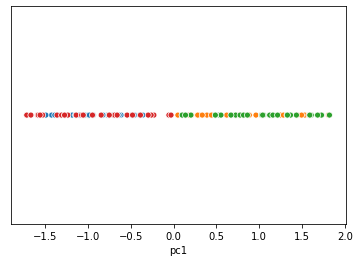

<IPython.core.display.Javascript object>

In [9]:
sns.scatterplot("pc1", "zero", hue="group", data=df)
plt.yticks([])
plt.ylabel("")
plt.legend().remove()
plt.show()

PCA has done its thing and has captured as much variation in the data as possible in a single component (>50%).  But is this visualization the best way to represent the data? If our goal was to represent the data as a rolled up line of points, then this single principal component is not doing very well.

## Isomap

Modified from [`sklearn` documentation](https://scikit-learn.org/stable/modules/manifold.html):

> One of the earliest approaches to manifold learning is the Isomap algorithm, short for Isometric Mapping. Isomap can be viewed as an extension of Multi-dimensional Scaling (MDS) or Kernel PCA. Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points. Isomap can be performed with the object `Isomap`.
>
>
> #### The `Isomap` algorithm comprises three stages:
>
> 1. **Nearest neighbor search.** `Isomap` uses `sklearn.neighbors`. BallTree for efficient neighbor search.
> 
> * **Shortest-path graph search.** The most efficient known algorithms for this are Dijkstra’s Algorithm or the Floyd-Warshall algorithm. The algorithm can be selected by the user with the `path_method` keyword of `Isomap`. If unspecified, the code attempts to choose the best algorithm for the input data.
>
> * **Partial eigenvalue decomposition.** The embedding is encoded in the eigenvectors corresponding to the  largest eigenvalues of the  isomap kernel. The eigensolver can be specified by the user with the `eigen_solver` keyword of Isomap. If unspecified, the code attempts to choose the best algorithm for the input data.

We can visualize the nearest neighbors using only functions we've seen before (`pdist` & `squareform`) and `pandas` data manipulation.  If you're wanting to do a nearest neighbors search in practice, look into `sklearn.neighbors.NearestNeighbors` or other more optimized searches (the search below isn't the most efficient but works well enough here because we have small data).

In [10]:
def find_neighbors(dist_df, n_neighbors=5):
    # Isolate column i
    col = dist_df.iloc[:, i]
    # Set self distance to NA
    col[i] = np.nan

    # Sort and take the index of the top n closest
    sorted_neigh = col.sort_values()
    top_neigh = sorted_neigh.head(n_neighbors)
    neigh_idxs = list(top_neigh.index)

    return neigh_idxs

<IPython.core.display.Javascript object>

In [11]:
def plot_neighbors(df, idx, neigh_idxs, alpha=0.1):
    # Pull out current rows coords
    ctr_pt = df.iloc[idx, [0, 1]].values
    for neigh_idx in neigh_idxs:
        # Pull out neighbor i's coords
        nn_pt = df.iloc[neigh_idx, [0, 1]].values

        # Plot line from center to each neighbor
        xs = [ctr_pt[0]] + [nn_pt[0]]
        ys = [ctr_pt[1]] + [nn_pt[1]]

        plt.plot(xs, ys, c="black", alpha=alpha, zorder=-1)

<IPython.core.display.Javascript object>

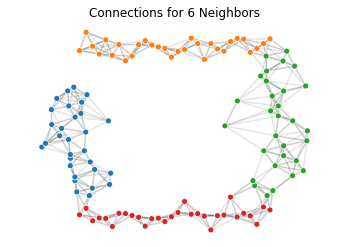

<IPython.core.display.Javascript object>

In [12]:
# Number of neighbors to find/plot
n_neighbors = 6

dist_mat = squareform(pdist(scaled))
dist_df = pd.DataFrame(dist_mat)

sns.scatterplot("x", "y", hue="group", data=df)

for i, _ in df.iterrows():
    neigh_idxs = find_neighbors(dist_df, n_neighbors)
    plot_neighbors(df[["x", "y"]], i, neigh_idxs)

plt.title(f"Connections for {n_neighbors} Neighbors")
plt.axis("off")
plt.legend().remove()
plt.show()

The next step of the algorithm is to create a distance matrix again, but this time, use *geodisic* distance.  Geodisic distance is a measure of how far apart points are in a graph of 'nodes' connected by 'edges' (like our scatter plot above).  If you had to follow the graph's edges, how many edges would you pass through to get from point A to point B?  That number of edges represents the geodisic distance that will be in our distance matrix.

After some processing of these distances, we'll perform eigenvalue decomposition on our matrix.  Think PCA, we'll get out a number of components that attempt to capture the information in our distance matrix.  If we asked for <=2 components then we can easily plot and visualize our data that might have had 2 many dimensions to easily visualize before.

This process is a case of Multi Dimensional Scaling (MDS).  MDS does the same PCA-like process to a distance matrix, traditionally, this was a Euclidean distance matrix, but the process can be applied to any distance/dissimilarity matrix with varying results.

Apply an Isomapping to the data:

* Use 1 component
* Choose a number of neighbors
    * Plug this number into the viz above to view what the map would look like for this number

In [13]:
iso = Isomap(n_neighbors=6, n_components=1)
df["iso"] = iso.fit_transform(scaled)

<IPython.core.display.Javascript object>

Plot the results in the same way as PCA was plotted above

Play with the number of neighbors and guess how it will effect the results.

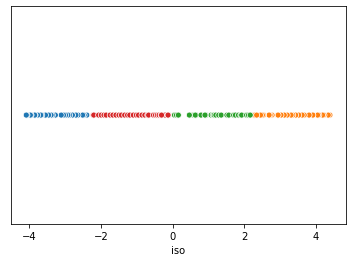

<IPython.core.display.Javascript object>

In [14]:
sns.scatterplot("iso", "zero", hue="group", data=df)
plt.yticks([])
plt.ylabel("")
plt.legend().remove()
plt.show()

Below, the 2 points we highlighted earlier are isolated.  We can see how PCA treated them, and how isomap treated them.

Verify, are these 2 points the maximum distance apart in our isomap data?

In [15]:
df[(df["x"] == 1.0) & (df["group"] == "b")]

,x,y,group,pc1,zero,iso
30,1.0,58.19488,b,0.050288,0,4.384174


<IPython.core.display.Javascript object>

In [16]:
df[(df["y"] == 43.5) & (df["group"] == "a")]

,x,y,group,pc1,zero,iso
29,0.997083,43.5,a,-0.391546,0,-4.087941


<IPython.core.display.Javascript object>

In [17]:
# Yes, these 2 points are as far away as possible in the Isomapped data
print(df["iso"].max())
print(df["iso"].min())

4.384174013579994
-4.08794128053441


<IPython.core.display.Javascript object>

## Locally Linear Embedding

Modified from [`sklearn` documentation](https://scikit-learn.org/stable/modules/manifold.html):

> Locally linear embedding (LLE) seeks a lower-dimensional projection of the data which preserves distances within local neighborhoods. It can be thought of as a series of local Principal Component Analyses which are globally compared to find the best non-linear embedding.
>
> #### The standard LLE algorithm comprises three stages:
>
> 1. **Nearest Neighbors Search.** See discussion under Isomap above.
>
> * **Weight Matrix Construction.** The construction of the LLE weight matrix involves the solution of a  linear equation for each of the  local neighborhoods
>
> * **Partial Eigenvalue Decomposition.** See discussion under Isomap above.

Steps 1 and 3 are the same as above.  So we just care about figuring out step 2.

Since step 3 is the same as above, that means that the output of step 2 is a matrix like our distance matrix (and it is also a square matrix).  In step 2 is where do the locally linear stuff.  We'll consider a single neighborhood in our plot (see below), our goal is to make a linear combination of the neighboring points such that they can recreate our point of interest.

For example, if we currently care about point $a$ we'll find its $n$ closest neighbors, lets say 3 for this.  We then want to find weights, $w$, so that:

$$a = w_1 * n_1 + w_2 * n_2 + w_3 * n_3$$

These weights are then put into a matrix, and that weights matrix is the output of step 2.

There are some mathematical issues that can come up if the number of neighbors is greater than the number of input dimensions (like our example is asking for 5 neighbors with only 2 input dimenions).  To address this problem, there is a `reg` parameter.  There is also Modified Locally Linear Embedding (MLLE), which we can use with `method='modifed'`.

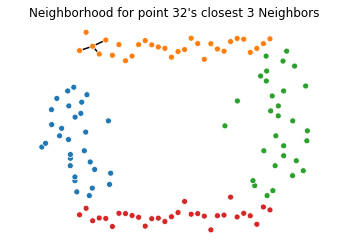

<IPython.core.display.Javascript object>

In [18]:
# Number of neighbors to find/plot
n_neighbors = 3
i = 32

dist_mat = squareform(pdist(scaled))
dist_df = pd.DataFrame(dist_mat)

sns.scatterplot("x", "y", hue="group", data=df)

neigh_idxs = find_neighbors(dist_df, n_neighbors)
plot_neighbors(df[["x", "y"]], i, neigh_idxs, alpha=1)

plt.title(f"Neighborhood for point {i}'s closest {n_neighbors} Neighbors")
plt.axis("off")
plt.legend().remove()
plt.show()

Repeat the process for `LocallyLinearEmbedding`

In [19]:
lle = LocallyLinearEmbedding(
    n_neighbors=5, n_components=1, reg=0.001, method="modified", random_state=42
)
df["lle"] = lle.fit_transform(scaled)

<IPython.core.display.Javascript object>

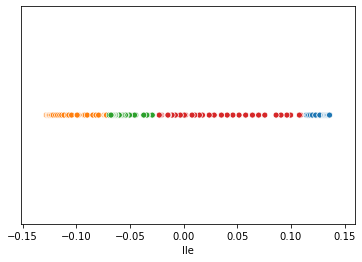

<IPython.core.display.Javascript object>

In [20]:
sns.scatterplot("lle", "zero", hue="group", data=df)
plt.yticks([])
plt.ylabel("")
plt.legend().remove()
plt.show()

## t-SNE

Modified from [`sklearn` documentation](https://scikit-learn.org/stable/modules/manifold.html):

> t-distributed Stochastic Neighbor Embedding (t-SNE) converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. This allows t-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques.
>
> While Isomap, LLE and variants are best suited to unfold a single continuous low dimensional manifold, t-SNE will focus on the local structure of the data and will tend to extract clustered local groups of samples. This ability to group samples based on the local structure might be beneficial to visually disentangle a dataset that comprises several manifolds at once as is the case in the digits dataset.
>
>
> The disadvantages to using t-SNE are roughly:
>
> t-SNE is computationally expensive, and can take several hours on million-sample datasets where PCA will finish in seconds or minutes
>
> The Barnes-Hut t-SNE method is limited to two or three dimensional embeddings.
>
> The algorithm is stochastic and multiple restarts with different seeds can yield different embeddings. However, it is perfectly legitimate to pick the embedding with the least error.
>
> Global structure is not explicitly preserved. This problem is mitigated by initializing points with PCA (using init='pca').
>
> ...
> 
> Larger perplexities lead to more nearest neighbors and less sensitive to small structure. Conversely a lower perplexity considers a smaller number of neighbors, and thus ignores more global information in favour of the local neighborhood. As dataset sizes get larger more points will be required to get a reasonable sample of the local neighborhood, and hence larger perplexities may be required. Similarly noisier datasets will require larger perplexity values to encompass enough local neighbors to see beyond the background noise.
>
> ...
> 
> Make sure the same scale is used over all features. Because manifold learning methods are based on a nearest-neighbor search, the algorithm may perform poorly otherwise. See `StandardScaler` for convenient ways of scaling heterogeneous data.

t-SNE cliff notes:

Consider each point in the original, high dimensional feature space.  Lets start with point $i$, make $i$ the center of our universe.  Every other point is some distance away from point $i$, instead of considering these as distances consider them as probabilities (higher probabilities are closer, more similar points; lower probabilities are further, less similar points).  If our input space is 2d, these probablities might look like the 3d plot below (where the height represents the probability and our point of interest is at the peak).

<img src='https://i.stack.imgur.com/QiTPe.png' width=30%>

We then create our lower dimensional mapping of the points (it won't be accurate to start), and measure distances here (that we also view as probabilities).  From here own out we iterate to optimize our mapping.  Our optimization's goal is to make the higher dimensional probabilites as similiar as possible to our lower dimensional probabilities.

Our main parameter is `perplexity`, and this will act similarly to `n_neighbors` in `Isomap` & `LLE`; that is, `perplexity`, will manage the trade-off of a local/global view of our points.  Lower `perplexity` -> more local view; higher `perplexity` -> more global view.

In [21]:
tsne = TSNE(n_components=1, perplexity=50.0, random_state=42)
df["tsne"] = tsne.fit_transform(scaled)

<IPython.core.display.Javascript object>

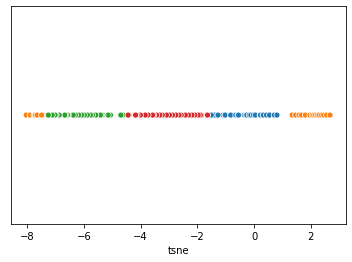

<IPython.core.display.Javascript object>

In [22]:
sns.scatterplot("tsne", "zero", hue="group", data=df)
plt.yticks([])
plt.ylabel("")
plt.legend().remove()
plt.show()

If you play around with perplexity enough, you'll see that t-SNE doesn't perform as well on this dataset as Isomap & LLE.  From above on t-SNE: "Isomap, LLE and variants are best suited to unfold a single continuous low dimensional manifold, t-SNE will focus on the local structure of the data and will tend to extract clustered local groups of samples".

Our example here is a single continuous manifold (its a single rolled up line of points).  More often than not, real world data won't be a single continuous manifold, and this is where t-SNE will outperform the other methods we've seen so far.

Note, t-SNE might not have done what we wanted here, but it still has done very well at grouping similar points.  We don't have a perfect unrolling of our original data, but we still visualized the original distances between points in a much better way than PCA does in this case.

## UMAP


Uniform Manifold Approximation and Projection (UMAP) has some similarities to t-SNE.  It measures distances between points in high dimensions and then maps these points to a lower dimension.  We then iterate on adjusting this map until the lower dimension representation has similar properties to the original high dimension data.  The key difference between these algorithms is the property that were comparing between the high & low dimensional represetations.

In t-SNE, we were looking at distances as a probability distribution and we we're trying to make this distribution look similar across low-d/high-d.  In UMAP, we're trying to make the topology look similar across low-d/high-d.

Think of topology like the below 3d dolphin picture, each vertex is one of our points in a higher dimensional space.  If we could unfold this dolphin and lay it flat, that could be an ideal representation of the data in 2d. This idea has some issues, like where would we cut the dolphin to fold it flat? Wherever we cut, we would be making points that were really close in 3d far apart in our 2d version.

<img src='https://upload.wikimedia.org/wikipedia/commons/f/fb/Dolphin_triangle_mesh.png' width=30%>


Ok, back to actually describing UMAP.  We'll find each points n nearest neighbors and keep track of these distances in each neighborhood (we're able to use different distances here). We then create our lower dimensional mapping of the points (it won't be accurate to start), and measure distances here between our neighborhood points (we'll use euclidean distance here).  From here on out we iterate to optimize our mapping.  Our optimization's goal is to make the higher dimensional distances as similiar as possible to our lower dimensional distances.  This is thought of as preserving the topological structure of our original data as best as possible.  UMAP claims to be better at t-SNE at preserving global structure, but this is not full agreed upon: [UMAP does not preserve global structure any better than t-SNE when using the same initialization](https://www.biorxiv.org/content/10.1101/2019.12.19.877522v1)

The main parameters we'll play with are `n_neighbors` (as we've seen before) and `min_dist` (which will control the placement of points in our lower d representation).

Play with both parameters below to see how it effects the output.

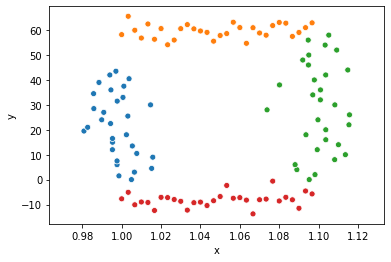

<IPython.core.display.Javascript object>

In [23]:
sns.scatterplot("x", "y", hue="group", data=df)
plt.legend().remove()
plt.show()

In [36]:
scaled.shape

(120, 2)

<IPython.core.display.Javascript object>

In [34]:
umap = UMAP(n_neighbors=5, min_dist=0.5, n_components=1, random_state=42)
df["umap"] = umap.fit_transform(scaled)

<IPython.core.display.Javascript object>

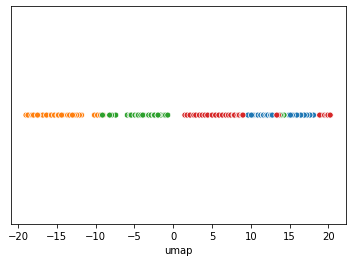

<IPython.core.display.Javascript object>

In [35]:
sns.scatterplot("umap", "zero", hue="group", data=df)
plt.yticks([])
plt.ylabel("")
plt.legend().remove()
plt.show()

Like t-SNE, UMAP doesn't do a perfect unrolling of our data (a single continuous manifold).  Again, this doesn't mean it wasn't successful in keeping similiar points close together and keeping dissimiliar points far apart.

So what's the big deal between t-SNE and UMAP?  They seem to have very similar ideas and very similar results on this data.

These 2 methods are very similar and in practice you might test both out and see which works better for your use case.  However, depending on your data's size, you'll be waiting on t-SNE to make this comparison.  UMAP's major advantage over t-SNE is the processing time. UMAP is much much faster than t-SNE when you have more and more data.  What is the cutoff point for what is too much data for t-SNE? ¯\\_(ツ)_/¯ your computer and patience will let you know.